In [2]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from scipy.stats import wasserstein_distance

from epuc.helpers.ensemble import Ensemble
from epuc.helpers.distance_analysis import (
    compute_wasserstein_distance,
    ecdf_values_ensemble,
    parametric_cdf_values_beta,
)
from epuc.configs import create_train_config

### Load individual models from Ensemble, as well as Second Order Predictor model:

In [3]:
save_path_classification_1000 = "../data/classification/new_simulation/shorter_run"
save_path_classification_100 = "../data/classification/new_simulation/short_run_100_samples"
save_path_classification_500 = "../data/classification/new_simulation/short_run_500_samples"
save_path_regression = "../data/regression/new_simulation/exp_1"
config_path_classification_1000 = "../data/classification/new_simulation/shorter_run/params.json"
config_path_classification_100 = "../data/classification/new_simulation/short_run_100_samples/params.json"
config_path_classification_500 = "../data/classification/new_simulation/short_run_500_samples/params.json"
config_path_regression = "../data/regression/new_simulation/exp_1/params.json"

# load configs from path 
with open(config_path_classification_1000, "r") as f:
    config_class_temp = json.load(f)
with open(config_path_regression, "r") as f:
    config_reg_temp = json.load(f)

config_classification = create_train_config(
    type="classification",
    lambda_reg = config_class_temp["lambda_reg"],
    ensemble_size=config_class_temp["ensemble_size"],
    ensemble_size_secondary=config_class_temp["ensemble_size_secondary"],
    hidden_dim=config_class_temp["hidden_dim"],
    n_hidden_layers=config_class_temp["n_hidden_layers"],
    
)


In [4]:
config_classification.keys()

dict_keys(['Bernoulli', 'Beta_outer_reg_0.0', 'Beta_inner_reg_0.0', 'Beta_outer_reg_0.001', 'Beta_inner_reg_0.001', 'Beta_outer_reg_0.01', 'Beta_inner_reg_0.01', 'Beta_outer_reg_0.05', 'Beta_inner_reg_0.05', 'Beta_outer_reg_0.1', 'Beta_inner_reg_0.1', 'Beta_outer_reg_0.5', 'Beta_inner_reg_0.5', 'Beta_outer_reg_1.0', 'Beta_inner_reg_1.0'])

In [5]:
# matplotlib parameters
plt.rcParams['image.cmap'] = 'viridis'
# latex as text renderer
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 20,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 18,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    # ticks
     "xtick.major.size": 10,
}
plt.rcParams.update(tex_fonts)
viridis = matplotlib.colormaps['viridis']
sns.set_palette("viridis", 4) 

### Do distance analysis for classification case:

In [6]:
dict_ensembles_1000 = {}
dict_ensembles_100 = {}
dict_ensembles_500 = {}
for ens in list(config_classification.keys())[:-8]:
    dict_ensembles_1000[ens] = Ensemble(model_config=config_classification[ens]["model_config"],
                                   ensemble_size=config_classification[ens]["ensemble_size"])
    dict_ensembles_100[ens] = Ensemble(model_config=config_classification[ens]["model_config"],
                                      ensemble_size=config_classification[ens]["ensemble_size"])
    dict_ensembles_500[ens] = Ensemble(model_config=config_classification[ens]["model_config"],
                                        ensemble_size=config_classification[ens]["ensemble_size"])
    
    dict_ensembles_1000[ens].load_models(save_path_classification_1000 + f"/{ens}/")
    dict_ensembles_100[ens].load_models(save_path_classification_100 + f"/{ens}/")
    dict_ensembles_500[ens].load_models(save_path_classification_500 + f"/{ens}/")

In [55]:
config_class_temp.keys()

dict_keys(['lambda_reg', 'n_epochs', 'lr', 'batch_size', 'reg_type', 'ensemble_size', 'ensemble_size_secondary', 'hidden_dim', 'n_hidden_layers', 'n_samples'])

In [9]:
def compute_wasserstein_dist_dict(dict_ensembles, x_values, theta_interval, n_splits):
    wasserstein_dict = {}
    primary_ensemble_models = dict_ensembles["Bernoulli"].models
    for ens in list(dict_ensembles.keys())[1:]:
        #print(ens)
        models_ens_secondary = dict_ensembles[ens].models
        w_distance, vars = compute_wasserstein_distance(ens_models = primary_ensemble_models,
                                                  second_order_models=models_ens_secondary,
                                                  x_values=x_values, theta_interval=theta_interval,
                                                 n_splits=n_splits)
        wasserstein_dict[ens] = w_distance
        wasserstein_dict[ens + "_vars"] = vars

    return wasserstein_dict

In [10]:
theta_interval = [0, 1]
x_values = np.linspace(0, 1, 100)

wasserstein_dict_1000 = compute_wasserstein_dist_dict(dict_ensembles_1000, x_values, theta_interval, 1000)
print("1000 samples computed")
wasserstein_dict_100 = compute_wasserstein_dist_dict(dict_ensembles_100, x_values, theta_interval, 100)
print("100 samples computed")
wasserstein_dict_500 = compute_wasserstein_dist_dict(dict_ensembles_500, x_values, theta_interval, 500)
print("500 samples computed")

1000 samples computed
100 samples computed
500 samples computed


compute averages for each number of samples and each setting

In [73]:
wasserstein_dict_500_avg = [np.mean(wasserstein_dict_500[ens]) for ens in list(wasserstein_dict_500.keys())]
wasserstein_dict_100_avg = [np.mean(wasserstein_dict_100[ens]) for ens in list(wasserstein_dict_100.keys())]
wasserstein_dict_1000_avg = [np.mean(wasserstein_dict_1000[ens]) for ens in list(wasserstein_dict_1000.keys())]

# print values of avaergae distances with first three decimals
print(np.round(wasserstein_dict_500_avg, 3))  #first three decimals
print(np.round(wasserstein_dict_100_avg, 3))
print(np.round(wasserstein_dict_1000_avg, 3))

print(wasserstein_dict_500.keys())


[0.057 0.147 0.065 0.138 0.051 0.137]
[0.114 0.162 0.102 0.114 0.105 0.124]
[0.086 0.176 0.101 0.161 0.085 0.134]
dict_keys(['Beta_outer_reg_0.0', 'Beta_inner_reg_0.0', 'Beta_outer_reg_0.001', 'Beta_inner_reg_0.001', 'Beta_outer_reg_0.01', 'Beta_inner_reg_0.01'])


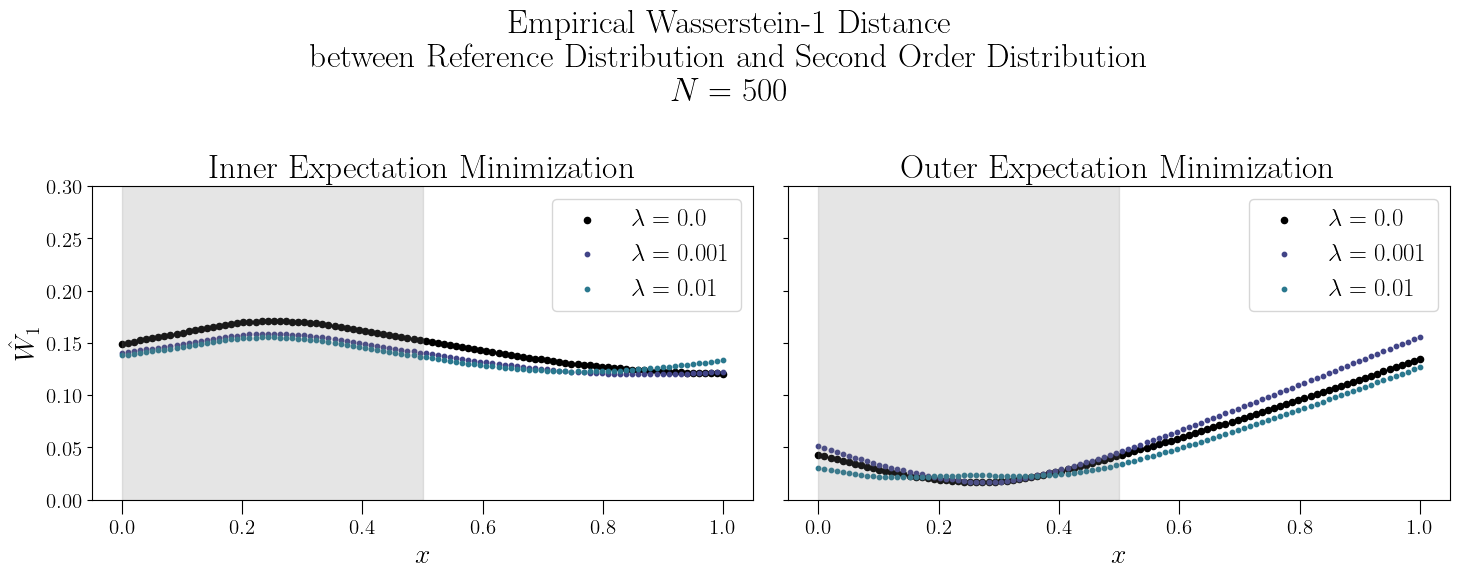

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
# load models from primary ensemble
# save wasserstein distanes in dictionary
for key in wasserstein_dict_500.keys():
    w_distance = wasserstein_dict_500[key]
    # plot wasserstein distance
    # check if ens contains inner or outer as substring
    if "inner" in key:
        # extract number in key
        ens = key.split("_")[3]
        if ens == "0.0":
            ax[0].scatter(x_values, w_distance, label=f"$\lambda={{{ens}}}$", s=20, color="black")
        else:
            ax[0].scatter(x_values, w_distance, label=f"$\lambda={{{ens}}}$", s=10)
            ax[0].set_title("Inner Expectation Minimization")
        ax[0].legend()
    else:
        ens = key.split("_")[3]
        if ens == "0.0":
            ax[1].scatter(x_values, w_distance, label=f"$\lambda={{{ens}}}$", s=20, color="black")
        else:
            ax[1].scatter(x_values, w_distance, label=f"$\lambda={{{ens}}}$", s=10)
        ax[1].set_title("Outer Expectation Minimization")
        ax[1].legend()

# shade interval [0,0.5] where we had training data
ax[0].axvspan(0, 0.5, alpha=0.2, color="gray")
ax[1].axvspan(0, 0.5, alpha=0.2, color="gray")

ax[0].set_xlabel("$x$", fontsize=20)
ax[1].set_xlabel("$x$", fontsize=20)
ax[0].set_ylabel("$\hat{W_1}$", fontsize=20)

# set ylim to [0.0, 0.3]
ax[0].set_ylim(0.0, 0.3)



plt.suptitle(f"Empirical Wasserstein-1 Distance \n between Reference Distribution and Second Order Distribution \n $N=500$")
plt.tight_layout()

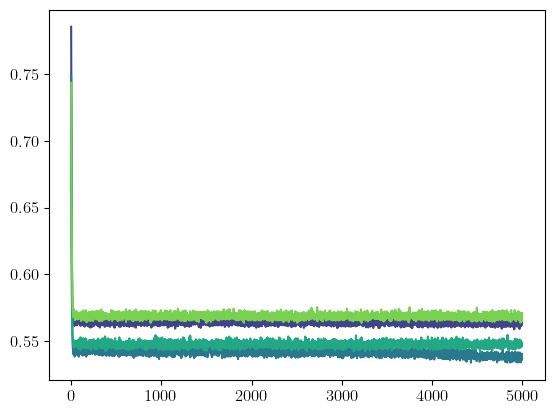

In [27]:
# get attributes of dict_ensembles["Beta_inner_reg_0.0"]
plt.plot(dict_ensembles["Bernoulli"].dict_losses[0])
plt.plot(dict_ensembles["Bernoulli"].dict_losses[1])
plt.plot(dict_ensembles["Bernoulli"].dict_losses[2])
plt.plot(dict_ensembles["Bernoulli"].dict_losses[3])
